Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Available devices  1
Current cuda device  0
GeForce GTX 1060 6GB
Batch size torch.Size([6, 3, 256, 256])
Intensity distribution [min:-1.000000, max:1.000000] [mean:-0.044401, std:0.479128]


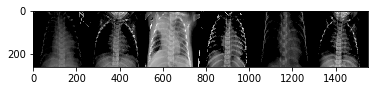

In [12]:
import torch

# 현재 Setup 되어있는 device 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())
print(torch.cuda.get_device_name(device))

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from torch.autograd.variable import Variable
import torch.nn.functional as F
import numpy as np
import os
from torchvision.utils import save_image

# Configs
BATCH_SIZE = 6
NUM_EPOCH = 4684 # Max number of epoch
LEARNING_RATE_G = 0.0002 # Change it depending on your generator model and optimizer_g
LEARNING_RATE_D = 0.0002 # Change it depending on your generator model and optimizer_g
CUDA = True # True => use gpu if it is available | False => use cpu
OUTPUT_PATH = 'C:/Users/user/Desktop/output/image/' # location for image outputs
MODEL_PATH = 'C:/Users/user/Desktop/output/model/' # location for checkpoints

# Apply configs
device = torch.device('cuda' if torch.cuda.is_available() and CUDA else 'cpu')
if not os.path.exists(OUTPUT_PATH): os.makedirs(OUTPUT_PATH)
if not os.path.exists(MODEL_PATH): os.makedirs(MODEL_PATH)
    

# Dataset preparation
xform = transforms.Compose([
    torchvision.transforms.Grayscale(num_output_channels=3),
     transforms.Resize([256,256]),
    transforms.ToTensor(),
      transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

np.random.RandomState(seed=42)

# Read dataset
dset = torchvision.datasets.ImageFolder('C:/Users/user/Desktop/path/to', transform=xform)


# Split dataset into train and evalution sets
train_size = int(0.8 * len(dset))
test_size = len(dset) - train_size
train_dataset, eval_dataset = torch.utils.data.random_split(dset, [train_size, test_size])

# Create dataset loader
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=False)
eval_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=False)

def show(img):
    img = torchvision.utils.make_grid(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    
# Train set
dataiter = iter(train_loader)
img, _ = dataiter.next()
print('Batch size', img.size())
print('Intensity distribution [min:{:2f}, max:{:2f}] [mean:{:2f}, std:{:2f}]'
      .format(img.min().item(), img.max().item(), img.mean().item(), img.std().item()))
show(img)
time_all_time = 0

In [13]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        n_features = 256
        n_out = 256
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(    
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(1024, 1536),
            nn.LeakyReLU(0.2)
        )
        self.hidden3 = nn.Sequential(
            nn.Linear(1536, 2048),
            nn.LeakyReLU(0.2)
        )
        self.hidden4 = nn.Sequential(
            nn.Linear(2048, 2176),
            nn.LeakyReLU(0.2)
        )
        self.out = nn.Sequential(
            nn.Linear(2176, n_out),
            nn.Tanh()
        )


    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        x = self.hidden4(x)
        x = self.out(x)
        return x

In [14]:

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        n_features = 256
        n_out = 256
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 2176),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(2176, 2048),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(2048, 1536),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
        )
        self.hidden3 = nn.Sequential(
            nn.Linear(1536, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
        )
        self.hidden4 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
        )
        self.out = nn.Sequential(
            torch.nn.Linear(512, n_out),
            torch.nn.Sigmoid()
        )

    
    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        x = self.hidden4(x)
        x = self.out(x)
        return x

In [15]:
class GANLoss(nn.Module):
    def __init__(self):
        super(GANLoss, self).__init__()
        self.REAL_LABEL=1.0
        self.FAKE_LABEL=0.0
        self.fake_cache = None
        self.real_cache = None
        self.discriminator_loss = nn.BCELoss()
        
    def __call__(self, x, isreal):
        if isreal:
            if (self.real_cache is None) or (x.numel() != self.real_cache.numel()):
                self.real_cache = x.new_full(x.size(), self.REAL_LABEL, requires_grad=False)
                self.real_cache.to(x.device)
            target = self.real_cache
        else:
            if (self.fake_cache is None) or (x.numel() != self.fake_cache.numel()):
                self.fake_cache = x.new_full(x.size(), self.FAKE_LABEL, requires_grad=False)
                self.fake_cache.to(x.device)
            target = self.fake_cache

        return self.discriminator_loss(x, target)

In [16]:
G = AutoEncoder().to(device)
D = Discriminator().to(device)
optimizer_g = torch.optim.Adam(G.parameters(), lr=LEARNING_RATE_G)
optimizer_d = torch.optim.Adam(D.parameters(), lr=LEARNING_RATE_D)
reconstruction_loss = nn.MSELoss()
gan_loss = GANLoss()

In [17]:
def train(epoch):
    start = time.time()
    G.train()
    D.train()
    total_g_loss = 0.0
    total_d_loss = 0.0
    for i, (img, _) in enumerate(train_loader):
        # Create noise matrix for each sample in the batch.
        #img = img.view(img.size(0), -1)
        
        noise = (torch.randn(img.size())+1) * 0.1
        noisy_img = img + noise
        # Add noise to the ground truth image to obtain noisy input
        noisy_img = Variable(noisy_img).cuda()
        img = Variable(img).cuda()
        # Generator forward pass
        output = G(noisy_img)
        
        # Discrimiator forward pass
        
        #loss = gan_loss(output, img)
        #MSE_loss = reconstruction_loss(output, img)
        
        
        optimizer_d.zero_grad()
        # Train Real Data
        d_prediction_real = D(img)
        d_error_real = gan_loss(d_prediction_real, 1 )
        #d_error_real.backward(retain_graph=True )
        # Train Fake Data
        d_prediction_fake = D(output)
        d_error_fake = gan_loss(d_prediction_fake, 0 )
        #d_error_fake.backward(retain_graph=True )

        d_loss = (0.5 * d_error_real) + (0.5 * d_error_fake)
        d_loss.backward(retain_graph=True)
        optimizer_d.step()

        # Generator backward pass
        optimizer_g.zero_grad()
        g_prediction_fake = D(output)
        error = reconstruction_loss(output, img)
        g_error_fake = gan_loss(d_prediction_fake, 0 )
        #error.backward(retain_graph=True )
        #g_error_fake.backward()
        
        g_loss = (0.995 * error) + (0.005 * g_error_fake) 
        g_loss.backward()
        optimizer_g.step()

        # Update total losses
        total_d_loss +=  d_loss.item()
        total_g_loss += g_loss.item()
        # Print logs
        if i % 781 == 0:
            print('[{0:3d}/{1}] {2:3d}/{3} loss_g: {4:.4f} | loss_d: {5:4f}'
                .format(epoch+1, 100, i+1, len(train_loader), g_loss.item(), d_loss.item()))

        x = 0
        a = 99
        if epoch / a == 1 :   
            save_image(output.data[0], 'D:/noisy/poisson/output_image/{}_{}.png'.format(i,x), nrow=1, padding =1, normalize=True)
            save_image(img.data[0], 'D:/noisy/poisson/real_image/{}_{}.png'.format(i,x), nrow=1, padding =1, normalize=True)
            save_image(noisy_img.data[0], 'D:/noisy/poisson/noise_image/{}_{}.png'.format(i,x), nrow=1, padding =1, normalize=True)
            x+=1
        if epoch / a == 1 :
            save_image(output.data[1], 'D:/noisy/poisson/output_image/{}_{}.png'.format(i,x), nrow=1 ,padding =1, normalize=True)
            save_image(img.data[1], 'D:/noisy/poisson/real_image/{}_{}.png'.format(i,x), nrow=1, padding =1, normalize=True)
            save_image(noisy_img.data[1], 'D:/noisy/poisson/noise_image/{}_{}.png'.format(i,x), nrow=1, padding =1, normalize=True)
            x+=1
        if epoch / a == 1 :
            save_image(output.data[2], 'D:/noisy/poisson/output_image/{}_{}.png'.format(i,x), nrow=1, padding =1, normalize=True)
            save_image(img.data[2], 'D:/noisy/poisson/real_image/{}_{}.png'.format(i,x), nrow=1,padding=1, normalize=True)
            save_image(noisy_img.data[2], 'D:/noisy/poisson/noise_image/{}_{}.png'.format(i,x), nrow=1, padding =1, normalize=True)
            x+=1   
        if epoch / a == 1 :
            save_image(output.data[3], 'D:/noisy/poisson/output_image/{}_{}.png'.format(i,x), nrow=1, padding =1, normalize=True)
            save_image(img.data[3], 'D:/noisy/poisson/real_image/{}_{}.png'.format(i,x), nrow=1,padding =1, normalize=True)
            save_image(noisy_img.data[3], 'D:/noisy/poisson/noise_image/{}_{}.png'.format(i,x), nrow=1, padding =1, normalize=True)
            x+=1  
        if epoch / a == 1 :
            save_image(output.data[4], 'D:/noisy/poisson/output_image/{}_{}.png'.format(i,x), nrow=1, padding =1, normalize=True)
            save_image(img.data[4], 'D:/noisy/poisson/real_image/{}_{}.png'.format(i,x), nrow=1,padding =1, normalize=True)
            save_image(noisy_img.data[4], 'D:/noisy/poisson/noise_image/{}_{}.png'.format(i,x), nrow=1, padding =1, normalize=True)
            x+=1  
        if epoch / a == 1 :
            save_image(output.data[5], 'D:/noisy/poisson/output_image/{}_{}.png'.format(i,x), nrow=1, padding =1, normalize=True)
            save_image(img.data[5], 'D:/noisy/poisson/real_image/{}_{}.png'.format(i,x), nrow=1,padding =1, normalize=True)
            save_image(noisy_img.data[5], 'D:/noisy/poisson/noise_image/{}_{}.png'.format(i,x), nrow=1, padding =1, normalize=True)
    
    end = time.time()
    global time_all_time
    time_all_time += round(end - start,0)
    print('epoch_time:', round(end - start,0))
    # Calculate avarage loss for the current epoch
    avg_g_loss = total_g_loss / len(train_loader)
    avg_d_loss = total_d_loss / len(train_loader)
    print('Epoch[{}] Training Loss G: {:4f} | D: {:4f}'.format(epoch+1, avg_g_loss, avg_d_loss))
    
    return avg_g_loss, avg_d_loss

In [18]:
def evaluate(epoch):
    with torch.no_grad():

      G.eval()
      D.eval()
      total_g_loss = 0.0
      total_d_loss = 0.0
      for i, (img, _) in enumerate(eval_loader):
          # Create noise matrix for each sample in the batch.
          #img = img.view(img.size(0), -1)
          noise = (torch.randn(img.size())+1) * 0.1
          #noise = np.random.normal(0, 0.1, img_size)
          noisy_img = img + noise

          # Add noise to the ground truth image to obtain noisy input
          noisy_img = Variable(noisy_img).cuda()
          img = Variable(img).cuda()

          # Generator forward pass
          output = G(noisy_img)

          # Discrimiator forward pass

          optimizer_d.zero_grad()

          d_prediction_real = D(img)
          d_prediction_fake = D(output)

          # Calculate total loss for D
          d_error_real = gan_loss(d_prediction_real, 1 )
          d_error_fake = gan_loss(d_prediction_fake, 0 )
          d_loss = (0.5 * d_error_real) + (0.5 * d_error_fake)

          # Calculate total loss for G
          optimizer_g.zero_grad()
          g_prediction_fake = D(output)
          error = reconstruction_loss(output, img)
          g_error_fake = gan_loss(d_prediction_fake, 0 )

          g_loss = (0.995 * error) + (0.005 * g_error_fake) 

          # Update total losses
          total_d_loss += d_loss.item()
          total_g_loss += g_loss.item()
      avg_g_loss = total_g_loss / len(eval_loader)
      avg_d_loss = total_d_loss / len(eval_loader)
      print('Epoch[{}] Evaluation Loss G: {:4f} | D: {:4f}'.format(epoch+1, avg_g_loss, avg_d_loss))

      return avg_g_loss, avg_d_loss

In [ ]:
cache_train_g = []
cache_eval_g = []
cache_train_d = []
cache_eval_d = []
import time
for epoch in range(100):

    avg_train_g_loss, avg_train_d_loss = train(epoch)
    avg_eval_g_loss, avg_eval_d_loss = evaluate(epoch)
    # store training and evaluation loss for plotting
    cache_train_g.append(avg_train_g_loss)
    cache_eval_g.append(avg_eval_g_loss)
    cache_train_d.append(avg_train_d_loss)
    cache_eval_d.append(avg_eval_d_loss)

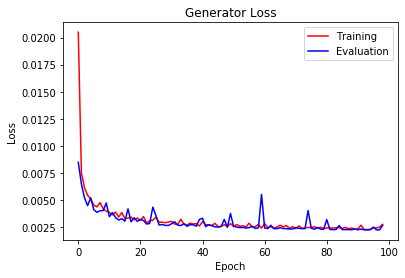

In [9]:
plt.plot(
    cache_train_g, 'r', 
    cache_eval_g, 'b')
plt.title('Generator Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training','Evaluation'])
plt.show()

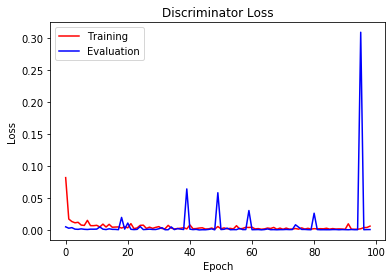

In [10]:
plt.plot(
    cache_train_d, 'r', 
    cache_eval_d, 'b')
plt.title('Discriminator Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training','Evaluation'])
plt.show()